<a id="top"></a>
# Table of Contents

[1. Functions](#functions)<br>
[2. Read and Clean](#read_clean)<br>
[3. Dataframe set up](#df_setup)<br>
[4. Findings](#findings)<br>

In [205]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

from scipy import stats

In [206]:

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

<a id="functions"></a>
## 1. Functions

In [207]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

In [208]:
def plot_hist_normalized(this_column, this_scaler: [str] = "standard_scaler"):
    if this_scaler == "power_transformator":
        pt = PowerTransformer()
        col_transformed_pt=pt.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_pt).set(title=f"{this_column.name} - PowerTransformer") 
    elif this_scaler == "quantile_transformer":
        qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
        col_transformed_qt=qt.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_qt).set(title=f"{this_column.name} - QuantileTransformer")
    else:
        sc = StandardScaler()
        col_transformed_sc=sc.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_sc).set(title=f"{this_column.name} - StandardScaler")

In [209]:
def boxplots_for_all_numerical_cols(this_df):
    fig, ax = plt.subplots(figsize=(10,10))
    len_num_lst = len(split_column_names_by(this_df)[0])
    i = 1
    for col in split_column_names_by(this_df)[0]:            
        plt.subplot(math.ceil(len_num_lst**.5),math.ceil(len_num_lst**.5),i)
        sns.boxplot(y=this_df[col]).set(title=f"{col}")
        i += 1

In [210]:
def split_df_by(this_df, include_dtypes:[list]=["int","float"]):
    """takes in this_df, splits it into two NEW DF's by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_df, excl_df)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (this_df[incl_lst], this_df[excl_lst])

In [211]:
def all_numeric_to_int(this_df):
    for col in this_df._get_numeric_data():
        this_df[col] = this_df[col].astype(np.int64)
    return this_df

In [212]:
def all_strings_lowercase(this_df):
    for col in this_df:
        this_df[col] = this_df[col].map(lambda x: x.lower() if isinstance(x,str) else x)
    return this_df

In [213]:
def nan_values_of_all_columns(this_df, return_dict:[bool] = False):
    """prints (defaults) or returns dictionary of all columns in this_df and their respective nan-values"""
    if not return_dict:
        for col in this_df.columns:
            print(col, this_df[col].isna().sum())
        return
    return {col:this_df[col].isna().sum() for col in this_df.columns}

In [214]:
def extract_year_month(this_date:[str]=None):
    # __author__ = "Roman Kaltschew"
    """takes this_date in format MM/DD/YYYY and returns YYYY_MM"""
    if this_date:
        return this_date.split("/")[2]+"_"+this_date.split("/")[0]
    return None

In [215]:
def extract_month(this_date:[str]=None, as_type:[str]=None):
    # __author__ = "Roman Kaltschew"
    """takes this_date in format MM/DD/YYYY and returns MM as_type (default str)"""
    if this_date:
        if as_type == "int":
            return int(this_date.split("/")[0])
        else:
            return str(this_date.split("/")[0])
    return None

In [216]:
def plot_long_lat():
    geometry = [Point(xy) for xy in zip(data['long'], data['lat'])]
    gdf = GeoDataFrame(df, geometry=geometry)   

    #this is a simple map that goes with geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)
    
    fig = px.scatter_geo(data,lat='lat',lon='long') #, hover_name="id")
    fig.update_layout(title = 'World map', title_x=0.5)
    fig.show()

In [217]:
def corr_mat(num_df):
    corr = num_df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(9, 7))
        ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

[top of notebook](#top)

<a id='read_clean'></a>

## 2 Read and Clean

In [218]:
data = pd.read_csv("data/regression_data.csv")
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


<a id="classifying_columns"></a>
### 2.1 Classifying columns

+ divide columns in numerical and discrete

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [220]:
for col in data.columns:
    data[col] = data[col].astype('category')

In [221]:
for col in ["sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "price", "sqft_living15", "sqft_lot15"]:
    data[col] = data[col].astype("int64")

In [222]:
#data["long"].value_counts()

[top of notebook](#top)

<a id="numericals"></a>
### 2.2 Numericals

#### 2.2.1 Check for NaNs

In [223]:
nan_values_of_all_columns(data[split_column_names_by(data)[0]])

sqft_living 0
sqft_lot 0
sqft_above 0
sqft_basement 0
sqft_living15 0
sqft_lot15 0
price 0


#### 2.2.2 Boxplots - check for outliers

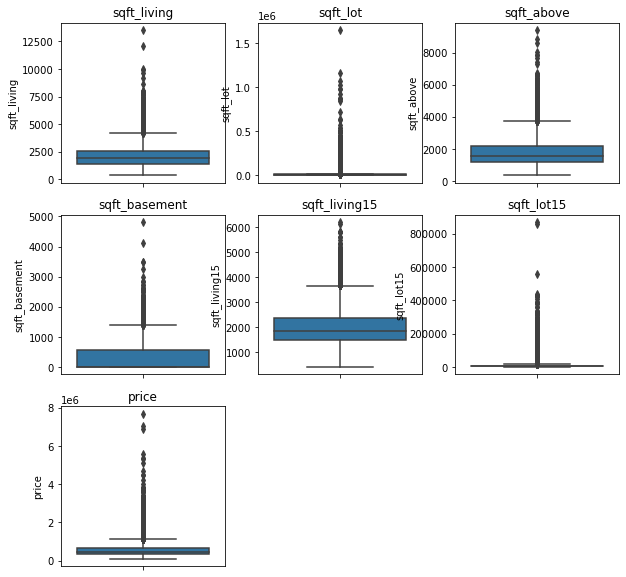

In [224]:
boxplots_for_all_numerical_cols(data)

##### bedroom outlier

In [225]:
data[data["bedrooms"] == max(data["bedrooms"])][["bedrooms","sqft_living"]]

,bedrooms,sqft_living
15856,33,1620


In [226]:
print(f"Average living space of tree bedrooms: {round(np.mean(data[data['bedrooms']==3]['sqft_living']), 2)}")
print(f"Average living space of two bedrooms: {round(np.mean(data[data['bedrooms']==2]['sqft_living']), 2)}")

Average living space of tree bedrooms: 1805.84
Average living space of two bedrooms: 1239.75


+ it is likely, that the 33 is a typo, it will be changed to 3

In [227]:
data.at[15856,"bedrooms"] = 3

##### sqft_lot outlier

In [228]:
print(data[data["sqft_lot"] == max(data["sqft_lot"])][["bedrooms","sqft_lot"]])

     bedrooms  sqft_lot
1717        4   1651359


In [229]:
print(f"Average lot in ft² of four bedrooms: {round(np.mean(data[data['bedrooms']==4]['sqft_lot']), 2)}")


Average lot in ft² of four bedrooms: 16720.79


+ it is likely, that a comma was forgotton, sqft_lot will be set to 16513.59

In [230]:
data.at[1717,"sqft_lot"] = 16513.59

##### sqft_living

In [231]:
# max sqft_living
data[data["sqft_living"] == max(data["sqft_living"])]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
12764,1225069038,5/5/2014,7,8.0,13540,307752,3.0,0,4,3,...,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,2280000


In [232]:
# sqft_living > 10000
data[data["sqft_living"] > 10000]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
3910,9808700762,6/11/2014,5,4.5,10040,37325,2.0,1,2,3,...,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,7060000
7245,6762700020,10/13/2014,6,8.0,12050,27600,2.5,0,3,4,...,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,7700000
12764,1225069038,5/5/2014,7,8.0,13540,307752,3.0,0,4,3,...,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,2280000


consider dropping these for modelling, as they don't represent a "normal" property in this dataset

##### sqft_basement

In [233]:
# max sqft_basement
data[data["sqft_basement"] == max(data["sqft_basement"])]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
8085,1924059029,6/17/2014,5,6.75,9640,13068,1.0,1,4,3,...,4820,4820,1983,2009,98040,47.557,-122.21,3270,10454,4670000


In [234]:
print(f"Average sqft_basement of five bedrooms: {round(np.mean(data[data['bedrooms']==5]['sqft_basement']), 2)}")
print(f"Average sqft_above of five bedrooms: {round(np.mean(data[data['bedrooms']==5]['sqft_above']), 2)}")

Average sqft_basement of five bedrooms: 639.98
Average sqft_above of five bedrooms: 2407.57


**??????????????**

##### Next outlier

In [235]:
(data[data["sqft_lot15"] == max(data["sqft_lot15"])])#[["bedrooms","sqft_lot"]])

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
9705,225079036,1/7/2015,4,4.0,5545,871200,2.0,0,0,3,...,3605,1940,2003,0,98014,47.676,-121.882,3420,871200,937500


In [236]:
(data[data["sqft_lot15"] == max(data["sqft_lot15"])])#[["bedrooms","sqft_lot"]])

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
9705,225079036,1/7/2015,4,4.0,5545,871200,2.0,0,0,3,...,3605,1940,2003,0,98014,47.676,-121.882,3420,871200,937500


In [237]:
data.sqft_lot15.value_counts()

5000     427
4000     356
6000     288
7200     210
4800     145
        ... 
10170      1
10573      1
11477      1
1449       1
2007       1
Name: sqft_lot15, Length: 8682, dtype: int64

##### Year renovated

In [238]:
data["yr_renovated"].value_counts()  

0       20683
2014       91
2013       37
2003       36
2007       35
        ...  
1951        1
1959        1
1934        1
1944        1
1954        1
Name: yr_renovated, Length: 70, dtype: int64

Unlikely, that most of the buildings were not renovated... drop column b/c incomplete

In [305]:
def return_year(this_date:[str]=None):
    return this_date.split("/")[2]

'1981'

In [311]:
aver_price_sqft_zipcode = data.groupby("zipcode").mean()[["price","sqft_living"]]

In [317]:
# aver_price_sqft_zipcode.to_csv("data/aver_price_sqft_zipcode.csv", encoding='utf-8', index=False)

In [312]:
aver_price_zipcode = data.groupby("zipcode").mean()[["price"]]

In [313]:
aver_sqft_zipcode = data.groupby("zipcode").mean()[["sqft_living"]]

<AxesSubplot:xlabel='zipcode'>

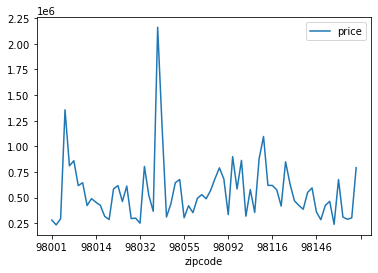

In [315]:
aver_price_zipcode.plot()

<AxesSubplot:xlabel='zipcode'>

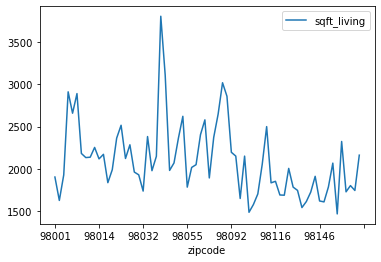

In [316]:
aver_sqft_zipcode.plot()

In [239]:
# placeholder

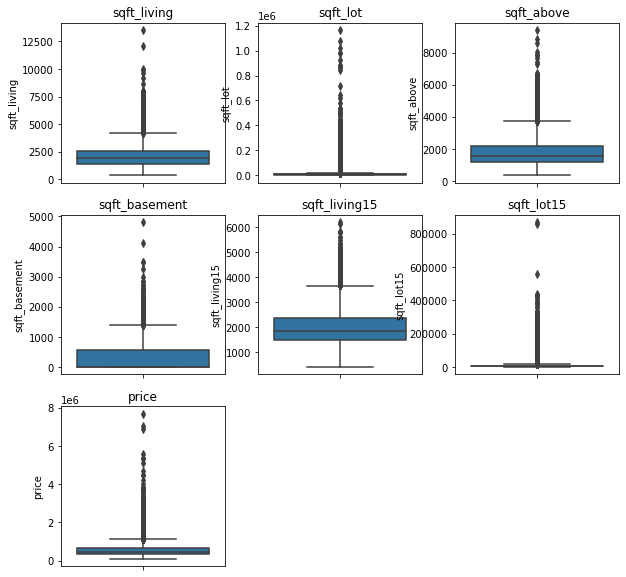

In [240]:
boxplots_for_all_numerical_cols(data)

#### 2.1.4 Change all numeric values to integer ???

+ no, as most of the data is already numerical and some data shouldn't be (long, lat, rooms, ...)

In [241]:
# data = all_numeric_to_int(ca_df)

<a id = "categoricals"></a>
### 2.3 Categorical columns

#### 2.2.1 Check for NaNs

In [242]:
nan_values_of_all_columns(data[split_column_names_by(data)[1]])

id 0
date 0
bedrooms 0
bathrooms 0
floors 0
waterfront 0
view 0
condition 0
grade 0
yr_built 0
yr_renovated 0
zipcode 0
lat 0
long 0


+ create month_sold column

In [243]:
data["month_sold"] = list(map(extract_month, data["date"]))

In [244]:
data["month_sold"] = data["month_sold"].astype('category')

<a id="drop_columns"></a>
### 2.4 Create modelling dataframe by dropping some columns

In [245]:
data.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price', 'month_sold'],
      dtype='object')

In [246]:
# model_df = data.copy()
# model_df.drop(["id", "date", "lat", "long", "yr_renovated"], axis=1, inplace=True)

In [247]:
# # uncomment if necessary
# data.to_csv("data/cleaned_data.csv", encoding='utf-8', index=False)

#### 2.2.3 All strings to lower case

In [248]:
# ca_df = all_strings_lowercase(ca_df)

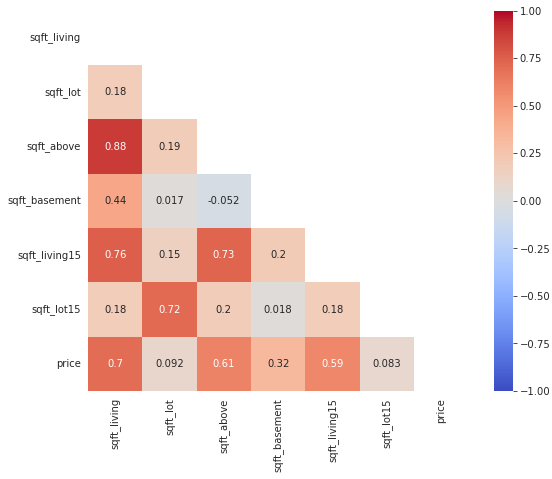

In [249]:
corr_mat(data)

+ drop sqft_above

[top of notebook](#top)

## 3. Adjust the DataFrame to fine tune the model

<a id="df_setup"></a>
### 3.1 Dataframe set up
Create a copy of the cleaned DataFrame to avoid multiple new runs of the cleaning process

In [253]:
this_model = data.copy()
len(this_model)

21597

**In the following cells, adjust the DataFrame**

In [254]:
# drop columns
this_model.drop(["id", "date", "yr_renovated", "long", "lat", "sqft_above"], axis=1, inplace=True)

In [255]:
# this_model.drop(this_model.index[list(data[data["sqft_living"] > 10000].index)], inplace=True)
this_model = this_model[this_model["price"] < 4000000]
this_model = this_model.reset_index(drop=True)
# this_model

Select scaling method by (un)commenting contents of the following cell:

In [256]:
scaler = "standard_scaler"
# scaler = "quantile_transformer"
# scaler = "power_transformator"  # not completely tested


Select the size of the test set

In [257]:
test_set_size = .30

Select further options:

In [258]:
show_boxplots_for_all_numerical = False
show_histograms_for_normalized_cols = False
show_hist_for_X = False
print_model_data = False
show_prediction_plots = True
show_beta_plot = True

When complete, run code and find the result under [output](#result).

#### 3.1.1 Numerical

In [259]:
if show_boxplots_for_all_numerical:
    boxplots_for_all_numerical_cols(split_df_by(this_model)[0])

In [260]:
if show_histograms_for_normalized_cols:
    for col in split_column_names_by(this_model)[0]:
        plot_hist_normalized(this_model[col], scaler)

#### 3.1.2 Categorical

In [261]:
categoricals_features= this_model.select_dtypes("category")
categoricals_features.reset_index(drop=True)

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,zipcode,month_sold
0,3,1.00,1.0,0,0,3,7,1955,98178,10
1,3,2.25,2.0,0,0,3,7,1951,98125,12
2,2,1.00,1.0,0,0,3,6,1933,98028,2
3,4,3.00,1.0,0,0,5,7,1965,98136,12
4,3,2.00,1.0,0,0,3,8,1987,98074,2
...,...,...,...,...,...,...,...,...,...,...
21580,3,2.50,3.0,0,0,3,8,2009,98103,5
21581,4,2.50,2.0,0,0,3,8,2014,98146,2
21582,2,0.75,2.0,0,0,3,7,2009,98144,6
21583,3,2.50,2.0,0,0,3,8,2004,98027,1


In [262]:
#cat_cols

In [263]:
#cat_cols=pd.get_dummies(categoricals_features, drop_first=True)

#### 3.1.3 X-y split

In [264]:
X=this_model.drop("price", axis=1)
y=this_model["price"]

In [265]:
X_num = X._get_numeric_data()
X_num = X_num.reset_index(drop=True)
X_num

,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15
0,1180,5650,0,1340,5650
1,2570,7242,400,1690,7639
2,770,10000,0,2720,8062
3,1960,5000,910,1360,5000
4,1680,8080,0,1800,7503
...,...,...,...,...,...
21580,1530,1131,0,1530,1509
21581,2310,5813,0,1830,7200
21582,1020,1350,0,1020,2007
21583,1600,2388,0,1410,1287


In [266]:
if show_hist_for_X:
    X_num.hist(figsize=(14,14))

In [267]:
# cat_cols

**Concat dummies to numeric standardized**

In [268]:
X = pd.concat([X_num,categoricals_features],axis=1)
X = X.reset_index(drop=True)
X

,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,zipcode,month_sold
0,1180,5650,0,1340,5650,3,1.00,1.0,0,0,3,7,1955,98178,10
1,2570,7242,400,1690,7639,3,2.25,2.0,0,0,3,7,1951,98125,12
2,770,10000,0,2720,8062,2,1.00,1.0,0,0,3,6,1933,98028,2
3,1960,5000,910,1360,5000,4,3.00,1.0,0,0,5,7,1965,98136,12
4,1680,8080,0,1800,7503,3,2.00,1.0,0,0,3,8,1987,98074,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21580,1530,1131,0,1530,1509,3,2.50,3.0,0,0,3,8,2009,98103,5
21581,2310,5813,0,1830,7200,4,2.50,2.0,0,0,3,8,2014,98146,2
21582,1020,1350,0,1020,2007,2,0.75,2.0,0,0,3,7,2009,98144,6
21583,1600,2388,0,1410,1287,3,2.50,2.0,0,0,3,8,2004,98027,1


#### 3.1.4 Data splitting

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size,random_state=42)

In [270]:
y_train.values.reshape(-1,1)
# y_test.values.reshape(-1,1)
y_train = y_train.reset_index(drop=True)


In [271]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [272]:
X_train
X_test

,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,zipcode,month_sold
0,1490,1294,270,1490,1283,3,2.25,2.0,0,0,3,7,2010,98106,6
1,1970,7213,800,1980,7045,4,2.75,1.0,0,0,3,8,1977,98058,5
2,1200,8631,0,1564,8115,3,1.75,1.0,0,0,3,7,1959,98198,2
3,980,5600,0,1840,5302,3,1.00,1.0,0,0,2,6,1949,98106,4
4,1580,1321,500,1530,1357,3,2.50,2.0,0,2,3,8,2014,98107,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6471,2760,3865,0,2590,4587,5,3.50,2.5,0,0,3,8,2013,98056,8
6472,1910,12596,570,1550,13310,3,1.75,1.0,0,0,3,7,1977,98072,6
6473,2380,6600,0,1870,6600,2,2.50,1.0,0,0,3,8,2010,98053,8
6474,2390,6820,250,1980,6820,4,2.75,2.0,0,0,4,7,1945,98115,11


#### 3.1.5 Standardize
+ Build scaling parameters on training set (mean variance) → more data as majority of datapoints of sample<br>(1 - *test_sample_size*) <br>



In [273]:
if scaler == "quantile_transformer":
    scaler_used = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(X_train)
elif scaler == "power_transformator":
    scaler_used = PowerTransformer().fit(X_train)
else:
    scaler_used = StandardScaler().fit(X_train)

+ Apply on training set

In [274]:
X_train_scaled=scaler_used.transform(X_train)

+ as well as on test set (same std_scaler but generated by a bigger set of values), same scaling param's as x_train

In [275]:
X_test_scaled=scaler_used.transform(X_test)

#### 3.1.6 Modeling using Statsmodels

In [276]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test.columns)

X_train_scaled = X_train_scaled.reset_index(drop=True)
X_test_scaled = X_test_scaled.reset_index(drop=True)


In [277]:
# y_train=y_train.values.reshape(-1,1)
# y_test=y_test.values.reshape(-1,1)


In [278]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant
# X_train_const_scaled = X_train_const_scaled.reset_index(drop=True)
model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
if print_model_data:
    print(print_model)

In [279]:
predictions_test

0       242120.183882
1       521272.177979
2       337067.869448
3       171157.318078
4       477281.836036
            ...      
6471    559662.009760
6472    354597.957318
6473    495410.615710
6474    604770.807685
6475    763266.751358
Length: 6476, dtype: float64

#### 3.1.7 Modeling using Scikit Learn

##### 3.1.7.1 Model fitting

In [280]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### 3.1.7.2 Parameters of model

In [281]:
model.coef_

array([ 1.16907989e+05,  3.72191130e+01,  3.36912254e+03,  2.73697452e+04,
       -1.45004730e+04, -3.07848527e+04,  3.51820311e+04,  1.86601582e+04,
        4.24385307e+04,  3.50865616e+04,  1.46743254e+04,  1.41686868e+05,
       -1.04453665e+05,  3.26072655e+02, -8.73683720e+03])

In [282]:
# print(list(zip(model.coef_, X_train.columns)))

In [283]:
coef_dict = {}
for coef, feat in list(zip(model.coef_, X.columns)):
    coef_dict[feat] = abs(coef)

In [284]:
# coef_dict_rev = {}
# for coef, feat in list(zip(model.coef_, X.columns)):
#     coef_dict_rev[str(abs(coef))] = feat

In [285]:
coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}
coef_dict

{'grade': 141686.8681476962,
 'sqft_living': 116907.98855972316,
 'yr_built': 104453.66474858821,
 'waterfront': 42438.53071886431,
 'bathrooms': 35182.0311031826,
 'view': 35086.56160662748,
 'bedrooms': 30784.85266613994,
 'sqft_living15': 27369.745245776376,
 'floors': 18660.15815506853,
 'condition': 14674.325416034586,
 'sqft_lot15': 14500.472999318592,
 'month_sold': 8736.837204775567,
 'sqft_basement': 3369.1225430035806,
 'zipcode': 326.0726552854935,
 'sqft_lot': 37.219112956826834}

In [286]:
coef_df = pd.DataFrame(coef_dict.items())

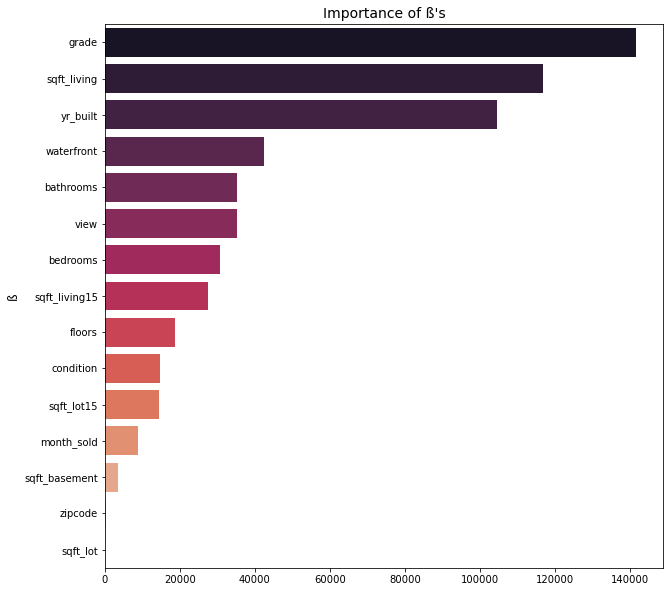

In [287]:
if show_beta_plot:
    fig, ax = plt.subplots(figsize=(10,10))
    sns.barplot(data=coef_df[:30], y=0, x=1, palette="rocket")
    ax.set_title("Importance of ß's", size=14)
    ax.set_ylabel("ß", fontsize=12)
    ax.set_xlabel("")


In [288]:
model.intercept_

536663.2939307697

In [289]:
model.score(X_test_scaled,y_test)

0.6773587059284052

##### 3.1.7.3 Making prediction

In [290]:
y_pred=model.predict(X_test_scaled)

In [291]:
# y_test

In [292]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### 3.1.7.4 Plots

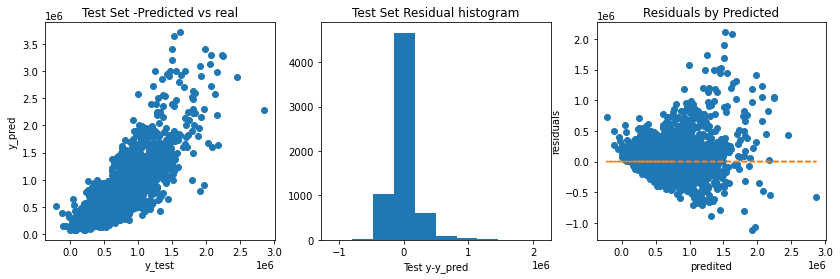

In [293]:
if show_prediction_plots:
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].plot(y_pred, y_test, 'o')
    ax[0].set_xlabel("y_test")
    ax[0].set_ylabel("y_pred")
    ax[0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1].hist(y_test - y_pred)
    ax[1].set_xlabel("Test y-y_pred")
    ax[1].set_title("Test Set Residual histogram")

    ax[2].plot(y_pred,y_test - y_pred,"o")
    ax[2].set_xlabel("predited")
    ax[2].set_ylabel("residuals")
    ax[2].set_title("Residuals by Predicted")
    ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

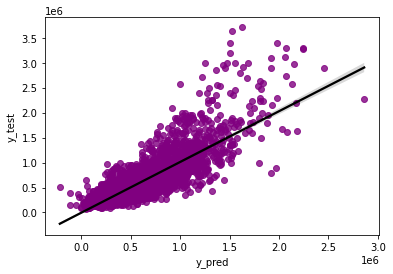

In [294]:
if show_prediction_plots:
    sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "purple"}, line_kws={"color": "black"})

##### 3.1.7.5 Error metrics Test

In [295]:
mse_test = mse(y_test,y_pred)
mae_test = mae(y_test,y_pred)

In [296]:
r2_test=r2_score(y_test,y_pred)


In [297]:
adj_r2_test= 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)


##### 3.1.7.6 Error metrics Train

In [298]:
y_pred=model.predict(X_train_scaled)

In [299]:
mse_train = mse(y_train,y_pred)
mae_train = mae(y_train,y_pred)

In [300]:
r2_train=r2_score(y_train,y_pred)


In [301]:
adj_r2_train= 1 - (1-r2_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)


***

<a id ="result"> </a>
### 3.2 Result Output

In [302]:
print(f"Adjusted Dataset contains {round(len(this_model)/len(data)*100,2)} % of original data points ({len(this_model)} out of {len(data)}).")
print("")
print("Error Metrics Test Set:\n")
print("         MSE =", round(mse_test, 4),"\n")
print("         MAE =", round(mae_test, 4),"\n")
print("          R² =", round(r2_test, 4),"\n")
print(" Adjusted R² =", round(adj_r2_test, 4),"\n")
print("\n---\n")
print("Error Metrics Train Set:","\n")
print("         MSE =", round(mse_train, 4),"\n")
print("         MAE =", round(mae_train, 4),"\n")
print("          R² =", round(r2_train, 4),"\n")
print(" Adjusted R² =", round(adj_r2_train, 4),"\n")

Adjusted Dataset contains 99.94 % of original data points (21585 out of 21597).

Error Metrics Test Set:

         MSE = 40883301711.9642 

         MAE = 133003.4477 

          R² = 0.6774 

 Adjusted R² = 0.6766 


---

Error Metrics Train Set: 

         MSE = 41544128703.6123 

         MAE = 136527.9245 

          R² = 0.6501 

 Adjusted R² = 0.6498 



Change DataFrame [set up](#df_setup) here.

[top of notebook](#top)

<a id='findings'> </a>
## 4. Findings


### 4.1 No further adjustments, long lat dropped, zipcode kept

Adjusted Dataset contains 100.0 % of original data points (21597 out of 21597).

Error Metrics Test Set:

         MSE = 48585422970.9826 

         MAE = 140817.5458 

          R² = 0.6336 

 Adjusted R² = 0.6327 


---

Error Metrics Train Set: 

         MSE = 45684575239.913 

         MAE = 139067.4107 

          R² = 0.664 

 Adjusted R² = 0.6636 

### 4.2 Excluding houses with sales prices < 4 Mio, long lat columns included (?)

`this_model = this_model[this_model["price"] < 4000000]`

Adjusted Dataset contains 99.94 % of original data points (21585 out of 21597).

Error Metrics Test Set:

         MSE = 35953732672.4518 

         MAE = 121377.2648 

          R² = 0.7163 

 Adjusted R² = 0.7155 


---

Error Metrics Train Set: 

         MSE = 35083542389.2531 

         MAE = 121760.0161 

          R² = 0.7045 

 Adjusted R² = 0.7042 


In [303]:
# def area_bla(price):
#     if price > 800k:
#         return expensive
#     elif price > 400K
#         return middle
#     else
#         return cheap

In [304]:
# zip_df[pricetag] = list(map(area_bla, average_col))